In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

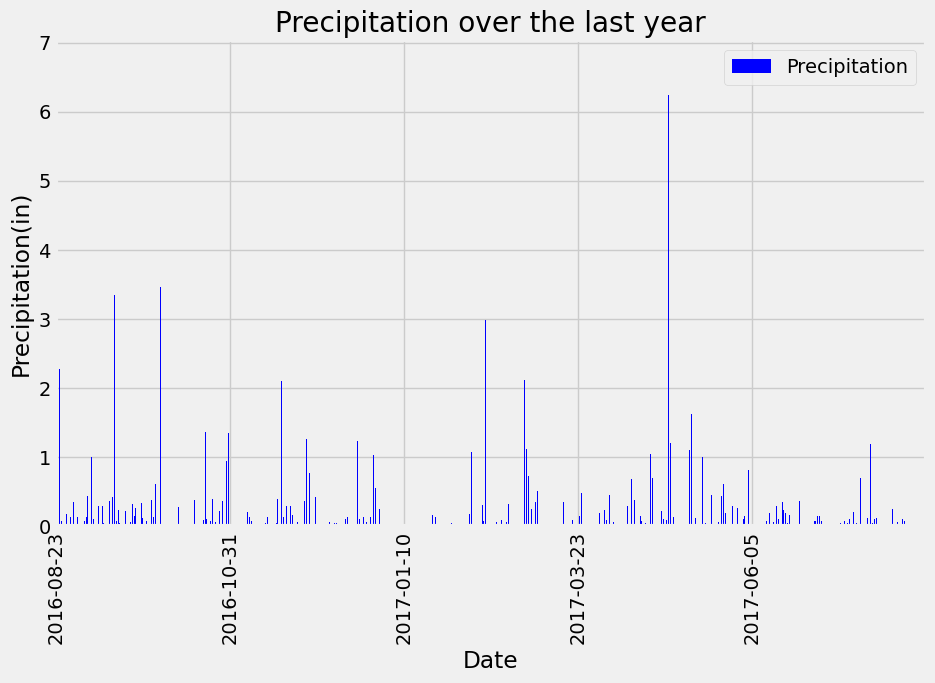

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mrd = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
oyld = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
p_score = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= oyld).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(p_score, columns=["Date","Precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(kind= "bar",figsize=(10,6),color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation(in)")
plt.title("Precipitation over the last year")
plt.xticks(np.arange(0,len(precipitation_df["Date"]),
                     step=len(precipitation_df["Date"])//5),
                     precipitation_df["Date"][::len(precipitation_df["Date"])//5])
plt.show()

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df["Precipitation"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(Station.station)).one()
stations

(9,)

In [38]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = activity[0][0]

temp = session.query(func.min(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active).all()
temp

[(54.0, 85.0, 71.66378066378067)]

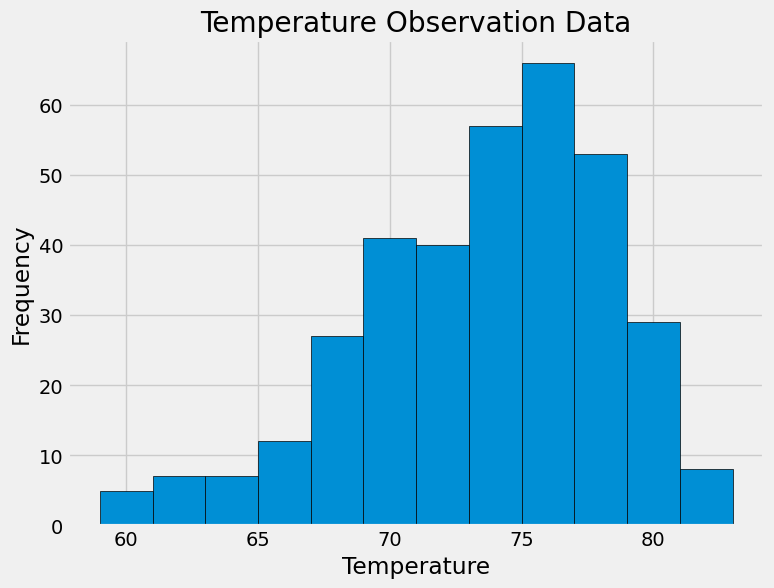

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

ltmt = mrd - pd.DateOffset(years=1)

observation = session.query(Measurement.tobs).\
              filter(Measurement.station == most_active).\
              filter(Measurement.date >= ltmt.strftime("%Y-%m-%d")).all()

temp_ob = [temp[0] for temp in observation]

plt.figure(figsize=(8,6))
plt.hist(temp_ob, bins = 12, edgecolor= "black")
plt.title("Temperature Observation Data")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()